### a). What percentage of users have churned in the data provided? [4 points]
### b). Build a classifier that given a user with their features assigns a churn probability for everyuser and predicts which users will churn. How well does your classifier perform? State any metrics you deem important here. Based on the classifier output classify each user in the dataset as churned or not churned. [5 points]
### c). List the most important features that correlate to user churn. [3 points]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import datetime
%matplotlib inline
plt.style.use('ggplot')

## 1. count chur rate by definition.

In [2]:
churned_user_set = set()

with open("equity_value_data.csv", newline = '') as csvfile:
    reader = csv.DictReader(csvfile)
    first_row = next(reader)
    prev_date = datetime.datetime.strptime(first_row["timestamp"], '%Y-%m-%dT%H:%M:%SZ')
    prev_user = first_row["user_id"]
    total_user = 1
    churned_user = 0
    cur_churned = False

    for row in reader:
        cur_user = row["user_id"]
        cur_date = datetime.datetime.strptime(row["timestamp"], '%Y-%m-%dT%H:%M:%SZ')
        if cur_user != prev_user:
            total_user = total_user + 1
            prev_user = cur_user
            cur_churned = False
        else:
            if((cur_date - prev_date).days >= 28 and not cur_churned):
                cur_churned = True
                churned_user = churned_user + 1
                churned_user_set.add(cur_user)
        prev_date = cur_date

In [3]:
print("total_user: " + str(total_user))
print("churned_user: " + str(churned_user))

total_user: 5584
churned_user: 279


In [4]:
print(churned_user / total_user)

0.04996418338108882


## a).  4.996% users have churned.

## 2. Import the features_data and do some preprocessing

In [5]:
df=pd.read_csv('features_data.csv')

In [6]:
df['churned'] = False
for i in range(len(df)):
    if df.at[i,'user_id'] in churned_user_set:
        df.at[i,'churned'] = True

In [7]:
discrete_column_names = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'platform', 'instrument_type_first_traded', 'time_horizon']    

In [8]:
df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churned
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,False
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,False
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,False
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,False
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,False


In [9]:
df_dummy = pd.get_dummies(df[discrete_column_names], columns=discrete_column_names)

There are many categories for this and we will see if this feature is not important, we can combine levels < 100 into 'instrument_others'.

In [10]:
df= df[['time_spent','first_deposit_amount','churned']].join(df_dummy)

#### We can look at the correlation matrix to determin which features are important

In [11]:
corr_matrix = df.corr()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 30 columns):
time_spent                                        5584 non-null float64
first_deposit_amount                              5584 non-null float64
churned                                           5584 non-null bool
risk_tolerance_high_risk_tolerance                5584 non-null uint8
risk_tolerance_low_risk_tolerance                 5584 non-null uint8
risk_tolerance_med_risk_tolerance                 5584 non-null uint8
investment_experience_extensive_investment_exp    5584 non-null uint8
investment_experience_good_investment_exp         5584 non-null uint8
investment_experience_limited_investment_exp      5584 non-null uint8
investment_experience_no_investment_exp           5584 non-null uint8
liquidity_needs_not_important_liq_need            5584 non-null uint8
liquidity_needs_somewhat_important_liq_need       5584 non-null uint8
liquidity_needs_very_important_liq_need           

In [13]:
corr_matrix['churned'].sort_values()

risk_tolerance_high_risk_tolerance               -0.065313
first_deposit_amount                             -0.029392
platform_iOS                                     -0.026258
time_horizon_med_time_horizon                    -0.017447
liquidity_needs_very_important_liq_need          -0.014718
instrument_type_first_traded_reit                -0.014549
investment_experience_good_investment_exp        -0.013607
instrument_type_first_traded_rlt                 -0.009214
time_horizon_long_time_horizon                   -0.006274
investment_experience_extensive_investment_exp   -0.005656
time_spent                                       -0.004667
instrument_type_first_traded_adr                 -0.003756
instrument_type_first_traded_tracking            -0.003069
instrument_type_first_traded_etp                 -0.000443
instrument_type_first_traded_cef                  0.000010
instrument_type_first_traded_stock                0.001976
instrument_type_first_traded_mlp                  0.0020

In [14]:
y = df['churned'].values

In [15]:
selected_features = list(df.columns)

In [16]:
df1=df.drop(['churned'],axis=1)

In [17]:
selected_features=list(df1.columns)
selected_features

['time_spent',
 'first_deposit_amount',
 'risk_tolerance_high_risk_tolerance',
 'risk_tolerance_low_risk_tolerance',
 'risk_tolerance_med_risk_tolerance',
 'investment_experience_extensive_investment_exp',
 'investment_experience_good_investment_exp',
 'investment_experience_limited_investment_exp',
 'investment_experience_no_investment_exp',
 'liquidity_needs_not_important_liq_need',
 'liquidity_needs_somewhat_important_liq_need',
 'liquidity_needs_very_important_liq_need',
 'platform_Android',
 'platform_both',
 'platform_iOS',
 'instrument_type_first_traded_0',
 'instrument_type_first_traded_adr',
 'instrument_type_first_traded_cef',
 'instrument_type_first_traded_etp',
 'instrument_type_first_traded_lp',
 'instrument_type_first_traded_mlp',
 'instrument_type_first_traded_reit',
 'instrument_type_first_traded_rlt',
 'instrument_type_first_traded_stock',
 'instrument_type_first_traded_tracking',
 'instrument_type_first_traded_wrt',
 'time_horizon_long_time_horizon',
 'time_horizon_me

In [18]:
X = df[selected_features].values

In [19]:
X.shape, y.shape

((5584, 29), (5584,))

## 3. Model training using random forest
- I choose random forest since it deals with categorical features well and we can get directly the feature importance.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators': 200,
              'max_features': 'auto',
              'max_depth': 20,
              'min_samples_leaf': 20,
              'random_state': 0,
              'n_jobs': -1
             }

clf = RandomForestClassifier(**parameters)

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [22]:
clf.score(X_train, y_train)

0.9514215357062906

In [23]:
clf.score(X_test, y_test)

0.9444941808415398

#### The accuracy score (for threshold 0.5) looks good. But the dataset is imbalanced, therefore we need to look at other metrics to evaluate the model.

In [24]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
# A method to print the metric scores
def get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred, threshold=0.5):
    metric_names = ['AUC', 'Accuracy', 'Precision', 'Recall', 'f1_score']
    metric_values_train = [roc_auc_score(y_train, p_train_pred),
                           accuracy_score(y_train, p_train_pred>threshold),
                           precision_score(y_train, p_train_pred>threshold),
                           recall_score(y_train, p_train_pred>threshold),
                           f1_score(y_train, p_train_pred>threshold)
                           ]
    metric_values_test = [roc_auc_score(y_test, p_test_pred),
                         accuracy_score(y_test, p_test_pred>threshold),
                         precision_score(y_test, p_test_pred>threshold),
                         recall_score(y_test, p_test_pred>threshold),
                         f1_score(y_test, p_test_pred>threshold)
                         ]
    
    all_metrics = pd.DataFrame({'metrics':metric_names,
                               'train': metric_values_train,
                               'test': metric_values_test}).set_index('metrics')
    print(all_metrics)

In [25]:
from sklearn.metrics import roc_curve

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green', lw=lw, 
            label = 'ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=lw,
            label = 'ROC Test (AUC = %0.4f)' % roc_auc_test, linestyle='--')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('The AOC curve')
    plt.legend(loc='lower right')
    plt.savefig('roc.png')
    plt.show()
   

In [26]:
def train_print_plot(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]
    
    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]
    
    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred, threshold=0.5)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


               test     train
metrics                      
AUC        0.615808  0.832915
Accuracy   0.944494  0.951422
Precision  0.000000  0.000000
Recall     0.000000  0.000000
f1_score   0.000000  0.000000


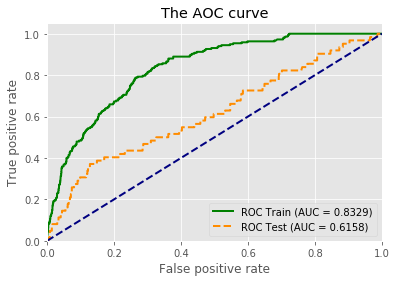

In [27]:
train_print_plot(clf, X_train, y_train, X_test, y_test)

#### There is some problem calculating some metrics. But we can infer from the AUC score that the performance is OK but there is much overfitting. Therefore I will use some oversampling method, SMOTE to get a balanced sample and train and evaluate the model again.

In [28]:
def plot_imp_tree(clf, selected_features):
    
    importances = clf.feature_importances_
    df_imp = pd.DataFrame({'feature': selected_features,
                           'importance': importances
                          }).sort_values(by=['importance'], ascending=True).set_index('feature')
    df_imp.plot.barh()
    plt.title('Importances of the variables')
    plt.tight_layout()
    #plt.figure(figsize=(80,80))
    print(df_imp)
    plt.show()

## Here is the anser for c)

                                                importance
feature                                                   
instrument_type_first_traded_rlt                  0.000000
instrument_type_first_traded_wrt                  0.000000
instrument_type_first_traded_lp                   0.000000
instrument_type_first_traded_tracking             0.000000
instrument_type_first_traded_cef                  0.000000
instrument_type_first_traded_0                    0.000000
instrument_type_first_traded_reit                 0.000171
investment_experience_extensive_investment_exp    0.000883
instrument_type_first_traded_mlp                  0.001009
instrument_type_first_traded_adr                  0.005580
instrument_type_first_traded_etp                  0.009329
liquidity_needs_not_important_liq_need            0.012630
time_horizon_med_time_horizon                     0.013083
instrument_type_first_traded_stock                0.017025
platform_Android                                  0.0204

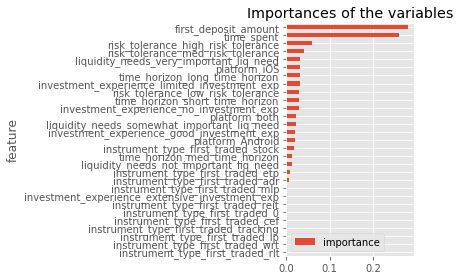

In [29]:
plot_imp_tree(clf, selected_features)

In [30]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [31]:
X_res, y_res = sm.fit_resample(X, y)

In [32]:
from collections import Counter
Counter(y_res)

Counter({False: 5305, True: 5305})

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)

In [34]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators': 200,
              'max_features': 'auto',
              'max_depth': 20,
              'min_samples_leaf': 20,
              'random_state': 0,
              'n_jobs': -1
             }

clf = RandomForestClassifier(**parameters)

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Answer for b) below is the performace of the model

               test     train
metrics                      
AUC        0.987096  0.986031
Accuracy   0.965598  0.962182
Precision  1.000000  0.999744
Recall     0.932532  0.924224
f1_score   0.965088  0.960502


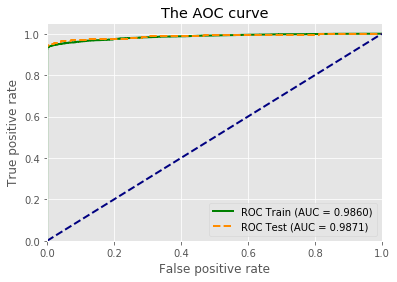

In [35]:
fig=train_print_plot(clf, X_train, y_train, X_test, y_test)
fig

#### It get better, but at the sacrifice of a relatively low recall score. We could change the threshold according out needs in order to get a good model.

## Summary
- First we difine the churn label.
- Then we use random forest classifier to train and predict the churn lables. Since the dataset is imbalanced, use SMOTE to do the oversampling and improve the model.
- Some other thoughts: 
    * We could use average close_equtity from the equity_value_data as a feature.
    * Group the unimportant instrument types to reduce the dimension.
    * Change the threshold to get a disired model.